<h2>Lightweight keyword spotting using attention-based
    recurrent neural networks</h2>
    
This demo is divided into 2 sections.

* In the first section it is shown the accuracy obtained by the Att25K model and it is possible to ear the misclassified original samples.

* In the second section it is possible to analyze a real time recording and see wether the model can actually identify the commands recorded from the pc microphone.

First of all we need to load the model and the test set.

In [1]:
import pyaudio
import wave
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import random
from Demo_utilities import *
import sys
sys.path.insert(1, '../')
from IPython.display import Audio, display, Image
np.random.seed(10)

model, test_reference, test_dataset, real_labels, test_steps, numToClass = load_everything()

model.summary()


Model: "AttRNNSpeechModel25K"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 126, 1)] 0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 126, 80, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 40, 32)   320         permute[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 63, 40, 32)   0           conv2d[0][0]                     
_______________________________________________________________________________

<h2>First section: accuracy on the test set</h2>

Compute the accuracy on the test set

In [2]:
with tf.device("/cpu:0"):
    accuracy = model.evaluate(test_dataset, steps=test_steps)
    pred_prob = model.predict(test_dataset, steps=test_steps)
        
probmax = np.max(pred_prob,1)
predictions = np.argmax(pred_prob, 1)


wrong=[]
right=[]
for i in range(predictions.shape[0]):
    if predictions[i] != real_labels[i]:
        wrong.append(i)
    else:
        right.append(i)
        
print(len(wrong), " Samples have been misclassified, out a total of ", predictions.shape[0])
file_paths = list(test_reference.index)


153/153 [==============================] - 3s 18ms/step - loss: 0.1120 - accuracy: 0.9661
166  Samples have been misclassified, out a total of  4890


And now we can analyze the samples that have been misclassified.
Running the cell below a random test sample that have been misclassified is selected. It is shown the predicted label and the real label, together with the relative probabilities that the model gives.


Predicted label :  up  with probability =  0.2252835
Real label :  unknown  had probability =  0.18338966


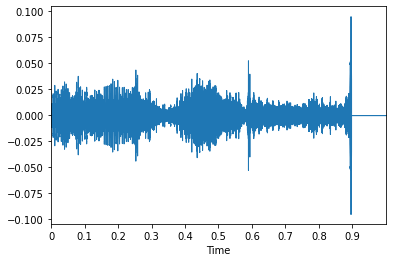

In [3]:
random_wrong_sample = np.random.randint(0,len(wrong)-1) 
y, sr = librosa.load("." + file_paths[wrong[random_wrong_sample]], 16000)
print("Predicted label : ","\033[1;31;10m"+ numToClass[predictions[wrong[random_wrong_sample]]], "\033[0;0;0m"+" with probability = ", probmax[wrong[random_wrong_sample]])
print("Real label : ","\033[1;32;10m" + numToClass[real_labels[wrong[random_wrong_sample]]], "\033[0;0;0m"+" had probability = ", pred_prob[wrong[random_wrong_sample],real_labels[wrong[random_wrong_sample]]])
librosa.display.waveplot(y, sr=sr)

Audio(data=y, rate=sr)

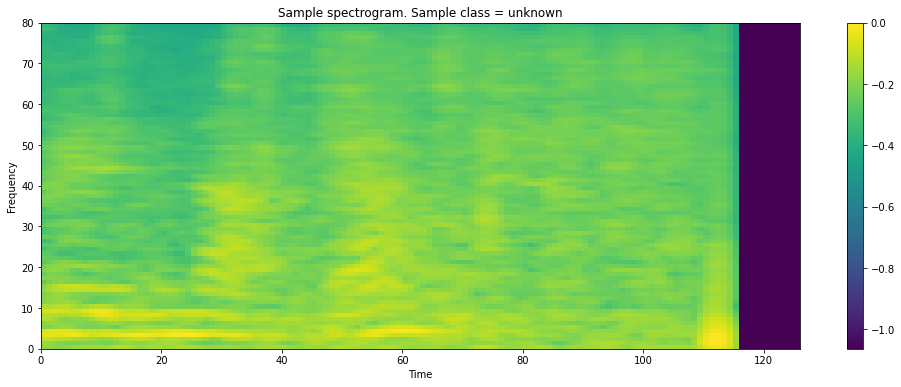

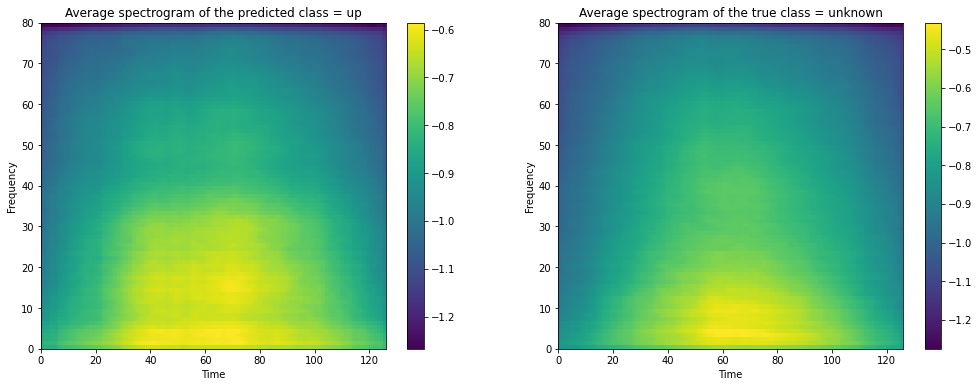

In [4]:
plot_spectrograms(y, sr, predictions[wrong[random_wrong_sample]],real_labels[wrong[random_wrong_sample]], numToClass)

Predicted label :  left  with probability =  0.74839
Real label :  up  had probability =  0.030389072


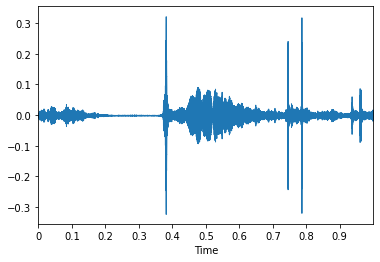

In [5]:
random_wrong_sample = np.random.randint(0,len(wrong)-1) 
y, sr = librosa.load("." + file_paths[wrong[random_wrong_sample]], 16000)
print("Predicted label : ","\033[1;31;10m"+ numToClass[predictions[wrong[random_wrong_sample]]], "\033[0;0;0m"+" with probability = ", probmax[wrong[random_wrong_sample]])
print("Real label : ","\033[1;32;10m" + numToClass[real_labels[wrong[random_wrong_sample]]], "\033[0;0;0m"+" had probability = ", pred_prob[wrong[random_wrong_sample],real_labels[wrong[random_wrong_sample]]])
librosa.display.waveplot(y, sr=sr)

Audio(data=y, rate=sr)

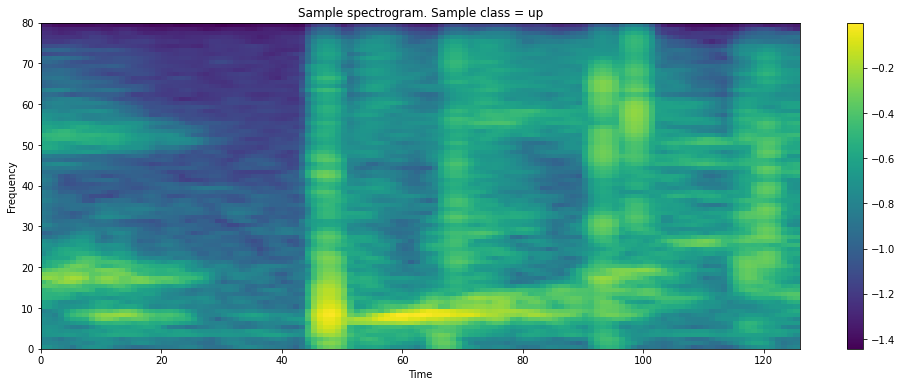

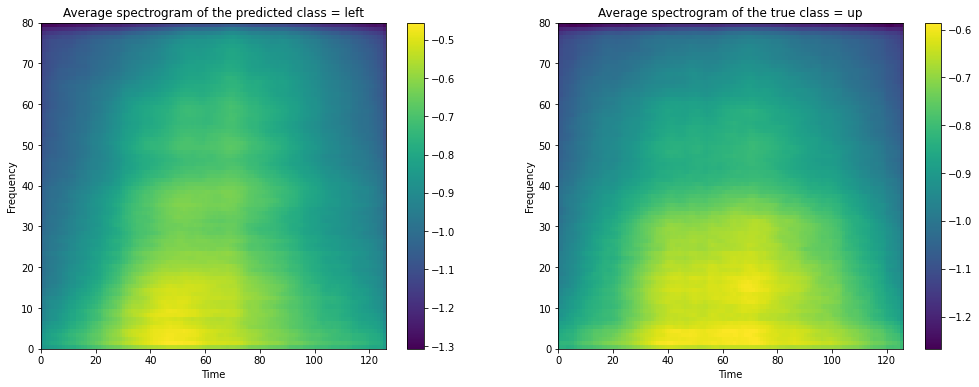

In [6]:
plot_spectrograms(y, sr, predictions[wrong[random_wrong_sample]],real_labels[wrong[random_wrong_sample]], numToClass)

<h2>Second section: continuous recording analysis</h2>

In order to better manage the silence samples we start by recording a baseline of background noise. The samples that are around this level of loudness are considered silence without even using our model.


In [7]:
loud_threshold=record_noise_sample()

Recording noise sample for 1 second...
Done!
Loud threshold 0.0051885042


By executing the next cell a recordining will start for 10 seconds: every command detected will appear on the screen

In [8]:
seconds = 10
# stop, go - left, right - on, off - yes, no - up, down
continuous_detection(model, 0.006*1.5, numToClass, seconds)

Started recording...
sample  1  loudness =  0.0032917066: nothing detected
sample  2  loudness =  0.01485096. Prediction  = stop  with probability  0.9999738
sample  3  loudness =  0.015981615. Prediction  = stop  with probability  0.9999502
sample  4  loudness =  0.004235053: nothing detected
sample  5  loudness =  0.015428676. Prediction  = go  with probability  0.99895906
sample  6  loudness =  0.013815935. Prediction  = go  with probability  0.99959964
sample  7  loudness =  0.01284392. Prediction  = left  with probability  0.9995264
sample  8  loudness =  0.021012839. Prediction  = left  with probability  0.9999298
sample  9  loudness =  0.010922759. Prediction  = unknown  with probability  0.8524713
sample  10  loudness =  0.020226276. Prediction  = right  with probability  0.958959
sample  11  loudness =  0.023376219. Prediction  = right  with probability  0.9979007
sample  12  loudness =  0.0061801695: nothing detected
sample  13  loudness =  0.027442984. Prediction  = on  with